# Explore here

In [64]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [65]:
%pip install numpy==1.23.5 scipy cython
%pip install pmdarima

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [66]:
# Import
# Basics
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

from pmdarima import auto_arima


In [67]:
# Get data
df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv")

# Initial Data Display
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [68]:
# DataFrame Dimensions
df.shape

(366, 2)

In [69]:
# Basic Information on Data Types and Non-Null Values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [70]:
# Search and Removal of Duplicate Data
duplicates = df.duplicated().sum()
duplicates

0

In [71]:
df["date"] = pd.to_datetime(df["date"])
df["date"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 366 entries, 0 to 365
Series name: date
Non-Null Count  Dtype         
--------------  -----         
366 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 3.0 KB


In [72]:
df = df.set_index('date') 

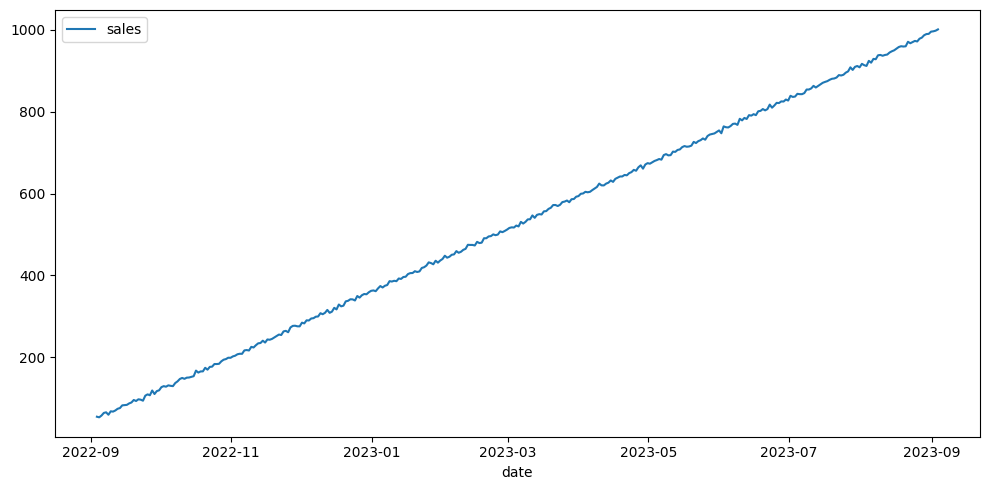

In [73]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = df)

# Adjust the Layout
plt.tight_layout()
# Display the Plot
plt.show()

In [74]:
decomposition = seasonal_decompose(df, period = 12)
decomposition

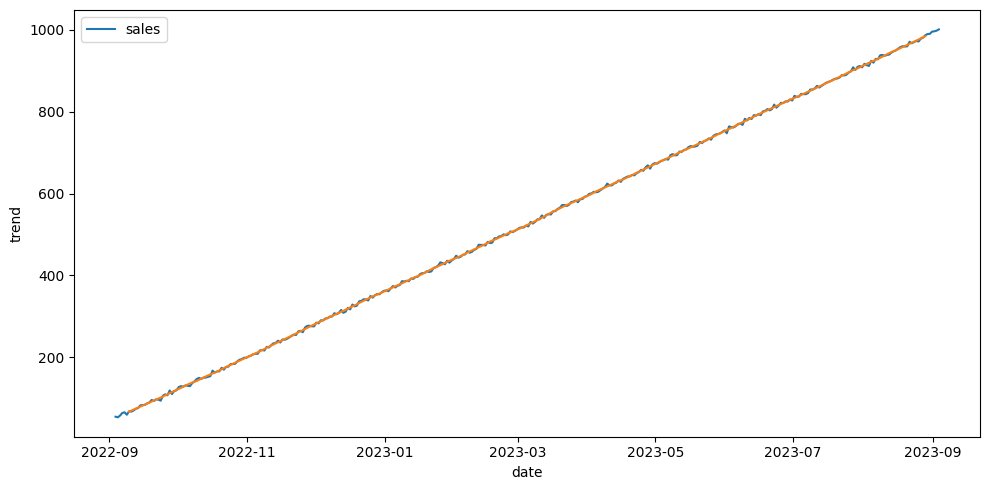

In [75]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = df)
sns.lineplot(data = trend)
# Adjust the Layout
plt.tight_layout()
# Display the Plot
plt.show()

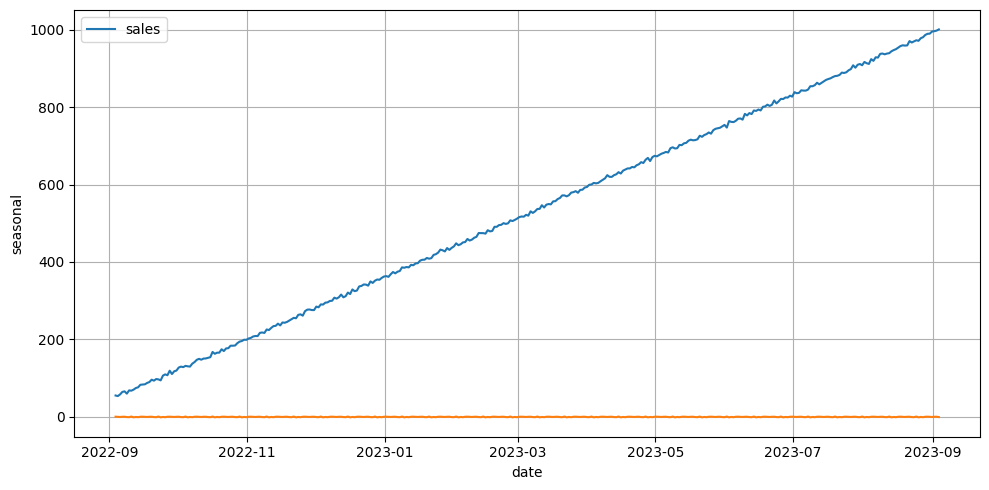

In [76]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = df)
sns.lineplot(data = seasonal)
# Adjust the Layout
plt.tight_layout()
# Display the Plot
plt.grid()
plt.show()

In [77]:
def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(df)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

<Axes: xlabel='date', ylabel='resid'>

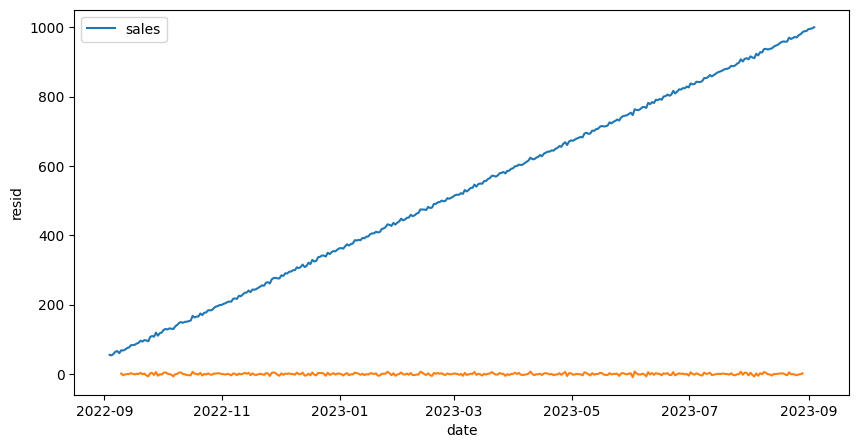

In [78]:
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = df)
sns.lineplot(data = residual)

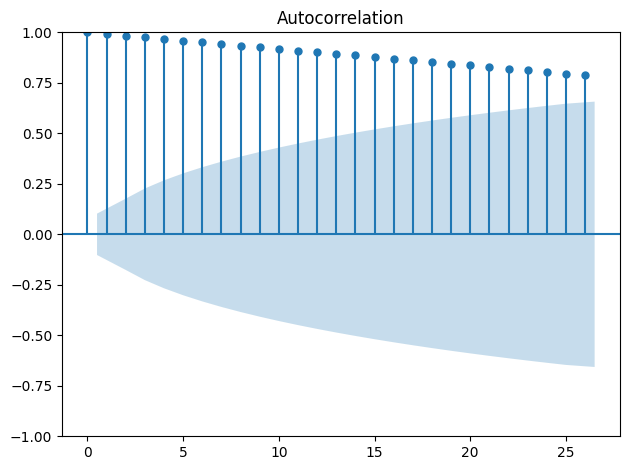

In [79]:
plot_acf(df)

plt.tight_layout()

plt.show()

In [80]:
df_stationary = df.diff().dropna()
test_stationarity(df_stationary)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

In [81]:
y = df_stationary.iloc[340:]
X = df_stationary.iloc[:340]

In [83]:
y.shape

(25, 1)

In [82]:
model = auto_arima(X, seasonal = True, trace = True, m = 30)

/workspaces/sergio-roque-time-series/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/workspaces/sergio-roque-time-series/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/workspaces/sergio-roque-time-series/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/workspaces/sergio-roque-time-series/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/workspaces/sergio-roque-time-series/.venv/lib/python3.11/site-packages/sklearn/utils/deprec

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[30] intercept   : AIC=1728.625, Time=3.25 sec
 ARIMA(0,0,0)(0,0,0)[30] intercept   : AIC=1965.915, Time=0.01 sec


/workspaces/sergio-roque-time-series/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/workspaces/sergio-roque-time-series/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[30] intercept   : AIC=1845.290, Time=0.65 sec


/workspaces/sergio-roque-time-series/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[30] intercept   : AIC=1723.638, Time=0.73 sec
 ARIMA(0,0,0)(0,0,0)[30]             : AIC=2068.244, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[30] intercept   : AIC=1724.737, Time=0.09 sec


/workspaces/sergio-roque-time-series/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/workspaces/sergio-roque-time-series/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/workspaces/sergio-roque-time-series/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,1)[30] intercept   : AIC=1725.900, Time=0.98 sec


/workspaces/sergio-roque-time-series/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,2)[30] intercept   : AIC=inf, Time=7.01 sec


/workspaces/sergio-roque-time-series/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,0)[30] intercept   : AIC=1723.709, Time=1.75 sec


/workspaces/sergio-roque-time-series/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,2)[30] intercept   : AIC=1727.573, Time=6.40 sec
 ARIMA(0,0,0)(0,0,1)[30] intercept   : AIC=1966.107, Time=0.19 sec


/workspaces/sergio-roque-time-series/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/workspaces/sergio-roque-time-series/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,1)[30] intercept   : AIC=1722.885, Time=1.14 sec


/workspaces/sergio-roque-time-series/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[30] intercept   : AIC=1724.091, Time=0.32 sec


/workspaces/sergio-roque-time-series/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,1)[30] intercept   : AIC=1725.323, Time=2.49 sec


/workspaces/sergio-roque-time-series/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,2)[30] intercept   : AIC=1724.838, Time=5.20 sec


/workspaces/sergio-roque-time-series/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,0)[30] intercept   : AIC=1722.989, Time=1.97 sec


/workspaces/sergio-roque-time-series/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,2)[30] intercept   : AIC=1726.884, Time=7.94 sec


/workspaces/sergio-roque-time-series/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,1)[30] intercept   : AIC=1845.438, Time=0.49 sec


/workspaces/sergio-roque-time-series/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,1)[30] intercept   : AIC=1724.888, Time=2.15 sec


/workspaces/sergio-roque-time-series/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,1)[30] intercept   : AIC=1727.533, Time=0.89 sec


/workspaces/sergio-roque-time-series/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,1)[30] intercept   : AIC=1722.932, Time=1.31 sec


/workspaces/sergio-roque-time-series/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,1)[30] intercept   : AIC=1797.794, Time=0.76 sec


/workspaces/sergio-roque-time-series/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,1)[30] intercept   : AIC=1726.749, Time=2.30 sec


/workspaces/sergio-roque-time-series/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,1)[30]             : AIC=inf, Time=1.34 sec

Best model:  ARIMA(1,0,1)(0,0,1)[30] intercept
Total fit time: 49.429 seconds


In [84]:
forecast = model.predict(25)
forecast

/workspaces/sergio-roque-time-series/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


2023-08-10 17:10:08.079328   -1.724121
2023-08-11 17:10:08.079328    3.741504
2023-08-12 17:10:08.079328    2.359529
2023-08-13 17:10:08.079328    2.530720
2023-08-14 17:10:08.079328    2.433782
2023-08-15 17:10:08.079328    2.701054
2023-08-16 17:10:08.079328    2.601738
2023-08-17 17:10:08.079328    2.544444
2023-08-18 17:10:08.079328    2.583561
2023-08-19 17:10:08.079328    2.862930
2023-08-20 17:10:08.079328    2.619334
2023-08-21 17:10:08.079328    2.159860
2023-08-22 17:10:08.079328    3.077088
2023-08-23 17:10:08.079328    2.658176
2023-08-24 17:10:08.079328    2.278870
2023-08-25 17:10:08.079328    2.581704
2023-08-26 17:10:08.079328    1.818979
2023-08-27 17:10:08.079328    3.569203
2023-08-28 17:10:08.079328    2.047916
2023-08-29 17:10:08.079328    2.715067
2023-08-30 17:10:08.079328    3.122886
2023-08-31 17:10:08.079328    2.018240
2023-09-01 17:10:08.079328    3.242093
2023-09-02 17:10:08.079328    3.023557
2023-09-03 17:10:08.079328    1.599918
Freq: D, dtype: float64

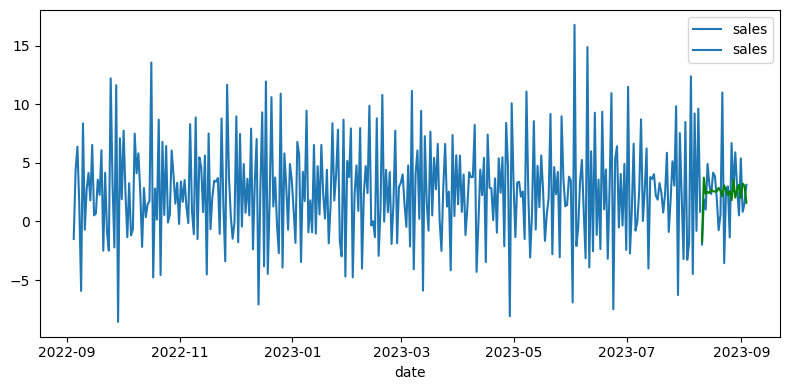

In [85]:
fig, axis = plt.subplots(figsize = (8, 4))

sns.lineplot(data = X)
sns.lineplot(data = y, c = "green")
sns.lineplot(data = forecast, c = "green")


plt.tight_layout()

plt.show()

In [ ]:
# Último valor de la serie original antes de diferenciar
last_value = ts.iloc[-1]

# Reconstruir las predicciones a partir del último valor conocido
forecast_original_scale = forecast.cumsum() + last_value